# Продажи Велосипедов

DataSet - bikes

In [2]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


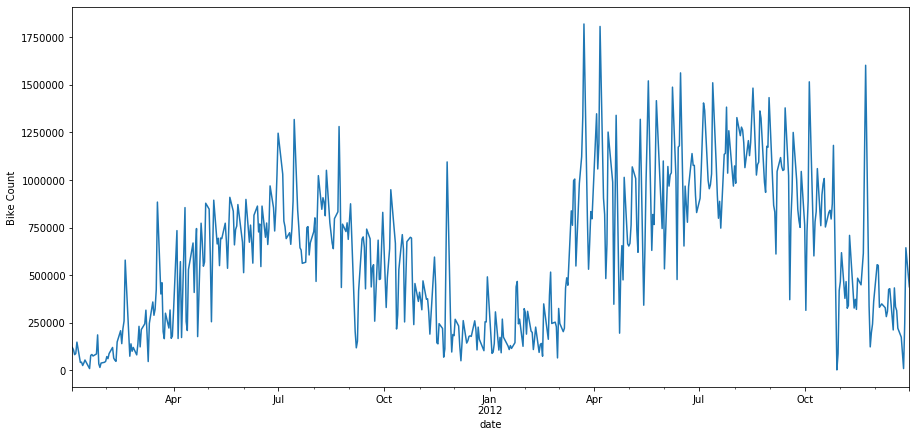

In [3]:
bikes = pd.read_csv('bikes.csv',',', index_col=['date'], parse_dates=['date'], dayfirst=True)
bikes.count = bikes['count'] * 1000
plt.figure(figsize(15,7))
bikes.count.plot()
plt.ylabel('Bike Count')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

 Критерий Дики-Фуллера: p=0.203653


<Figure size 1080x720 with 0 Axes>

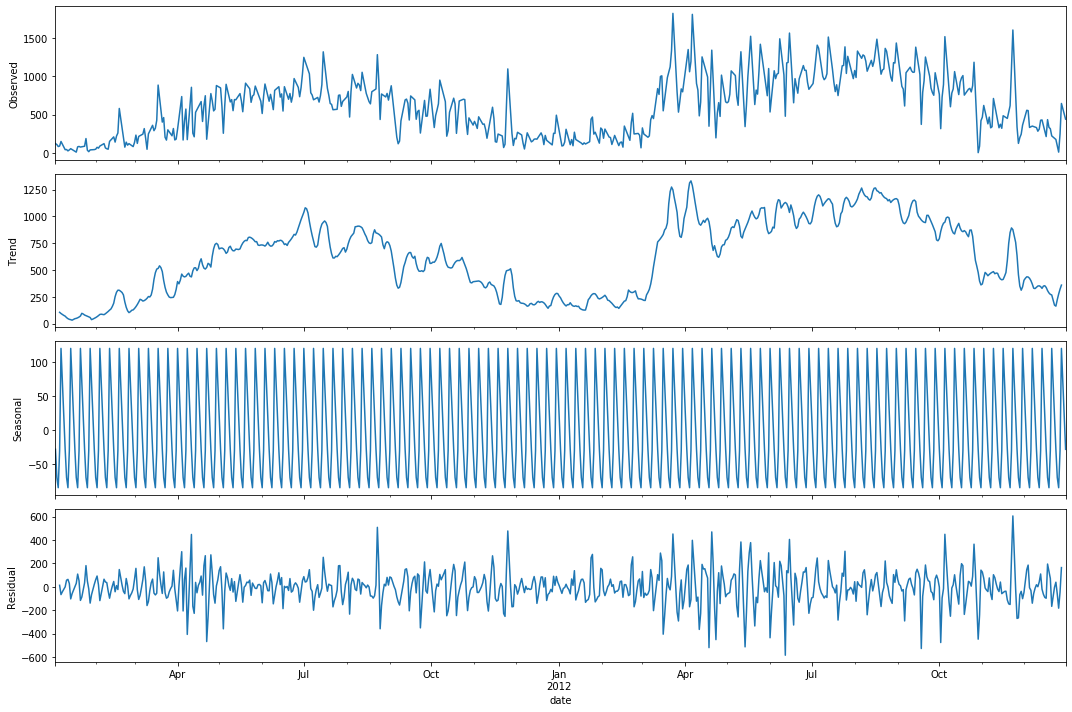

In [4]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(bikes['count']).plot()
print(" Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(bikes['count'])[1])

Из графика видно, что у нас имеются колебания. Необходимо стабилизировать дисперсию, для этого применяется(либо логорифмирование) либо преобразование Кокса-Бокса

### Стабилизация дисперсии

Преобразование Кокса- бокса для стабилизации дисперсии:

Оптимальный параметр преобразования Кокса- Бокса: 0.577641
 Критерий Дики-Фуллера: p=0.147631


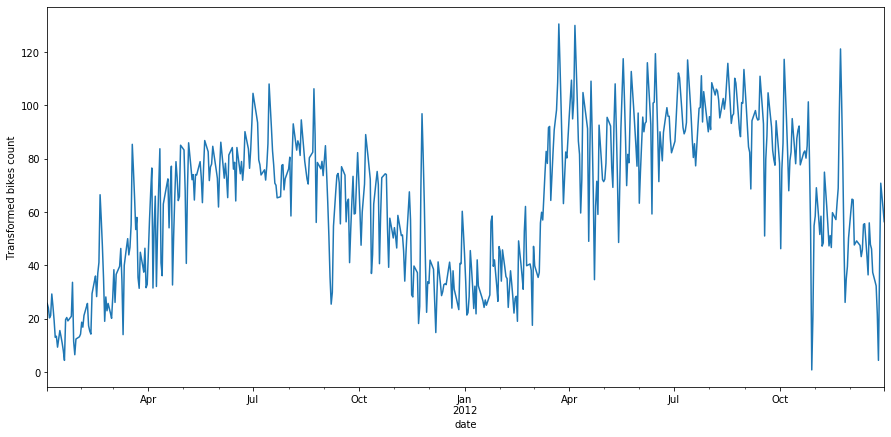

In [5]:
bikes['count_box'], lmbda = stats.boxcox(bikes['count'])
plt.figure(figsize(15,7))
bikes['count_box'].plot()
plt.ylabel(u'Transformed bikes count')
print("Оптимальный параметр преобразования Кокса- Бокса: %f" % lmbda)
print(" Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(bikes['count_box'])[1])

На графике мы видим продажи за два года, можем заметить,
что по месяцам продажи схожи - наблюдаем сезонность

### Стационарность

 Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

 ритерий Дики-Фуллера: p=0.000219


<Figure size 1080x720 with 0 Axes>

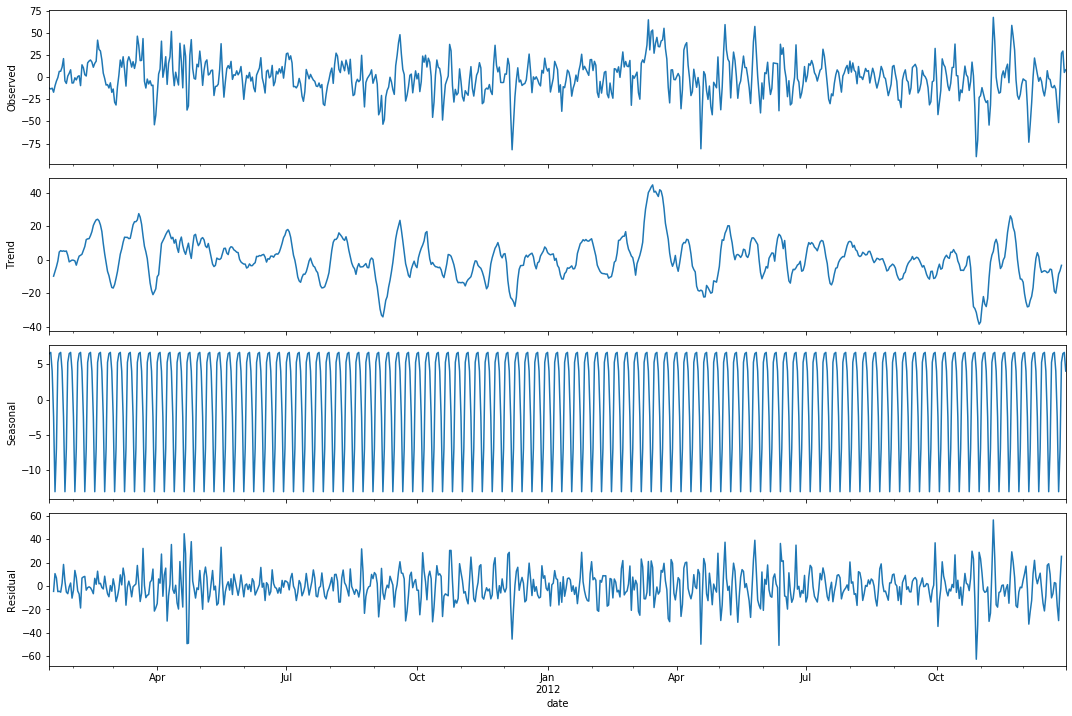

In [6]:
bikes['count_box_diff'] = bikes['count_box'] - bikes['count_box'].shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(bikes['count_box_diff'][12:]).plot()
print(" ритерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(bikes['count_box_diff'][12:])[1])

 Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить еще обычное дифференцирование:

 Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

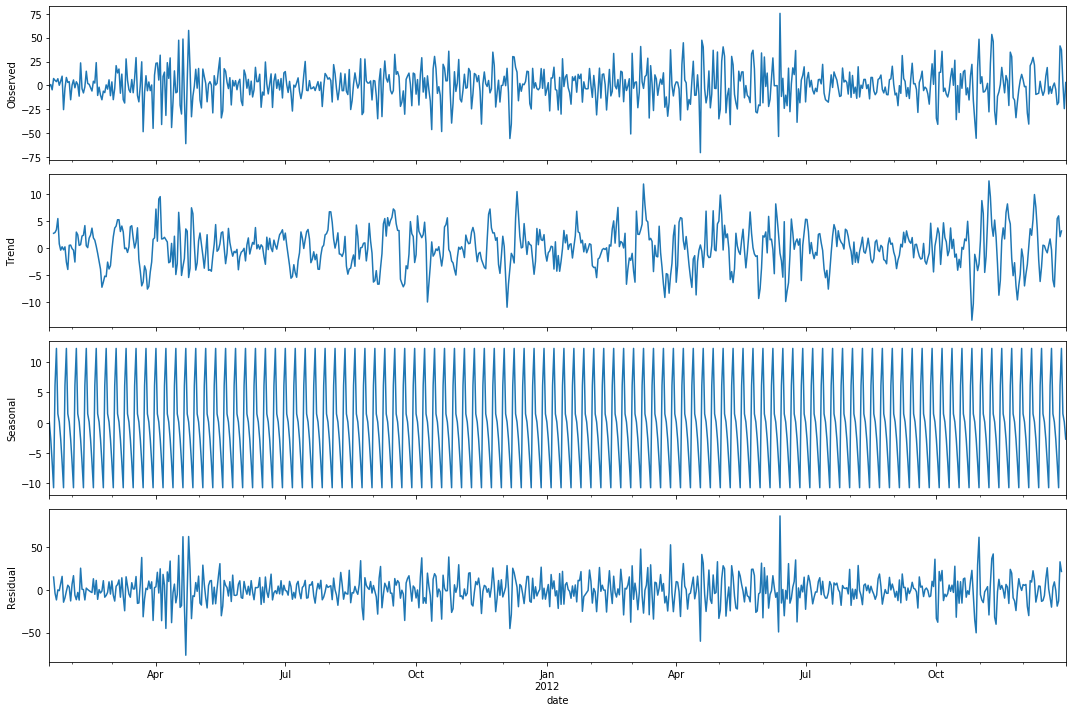

In [7]:
bikes['count_box_diff2'] = bikes['count_box_diff'] - bikes['count_box_diff'].shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(bikes['count_box_diff2'][13:]).plot()   
print(" Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(bikes['count_box_diff2'][13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

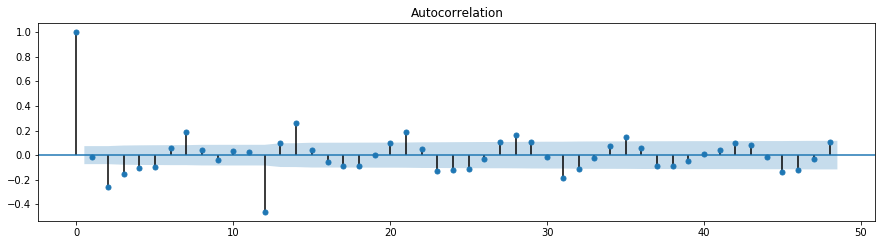

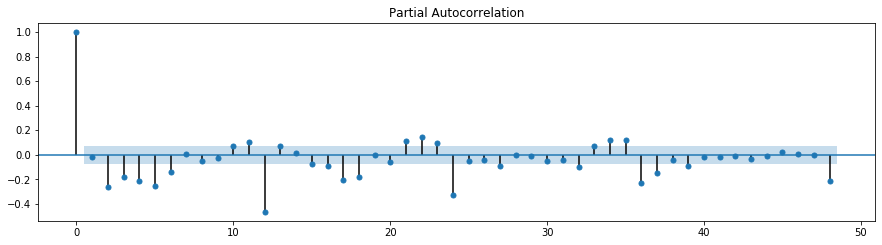

In [8]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(bikes['count_box_diff2'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(bikes['count_box_diff2'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближений: Q=1, q=2, P=1, p=4

In [9]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [10]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [11]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучаетс¤
    try:
        model=sm.tsa.statespace.SARIMAX(bikes['count_box'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохран¤ем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 4min 55s


In [12]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
33  (2, 2, 0, 1)  5542.373040
35  (2, 2, 1, 1)  5542.395926
53  (4, 1, 0, 1)  5543.072153
55  (4, 1, 1, 1)  5543.345224
47  (3, 2, 1, 1)  5544.289805


Лучшая модель:

In [13]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          count_box   No. Observations:                  729
Model:             SARIMAX(2, 1, 2)x(0, 1, 1, 12)   Log Likelihood               -2765.187
Date:                            Tue, 03 Mar 2020   AIC                           5542.373
Time:                                    17:46:07   BIC                           5569.815
Sample:                                01-03-2011   HQIC                          5552.970
                                     - 12-31-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0694      0.135      7.949      0.000       0.806       1.333
ar.L2         -0.4825      0.085   

Остатки:

 Критерий —Стьюдента: p=0.380114
 Критерий Дики-Фуллера: p=0.000000


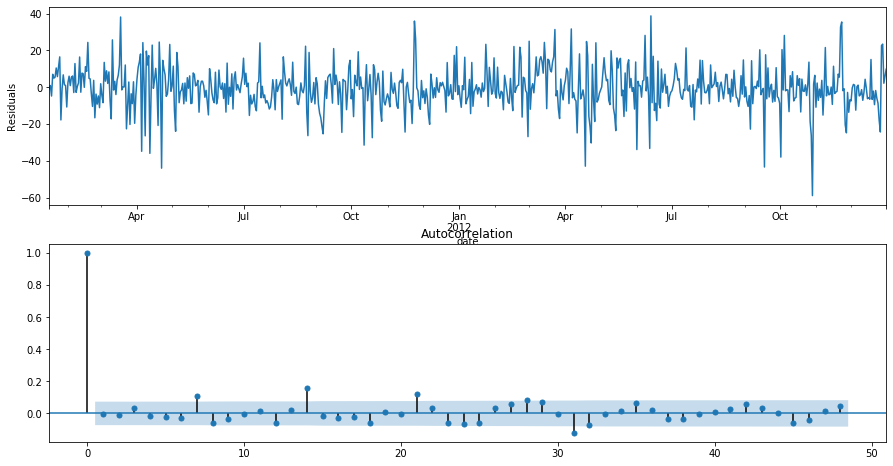

In [16]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print(" Критерий —Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print(" Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием —Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Тьюнга-Кокса и коррелограммой).
ѕосмотрим, насколько хорошо модель описывает данные:

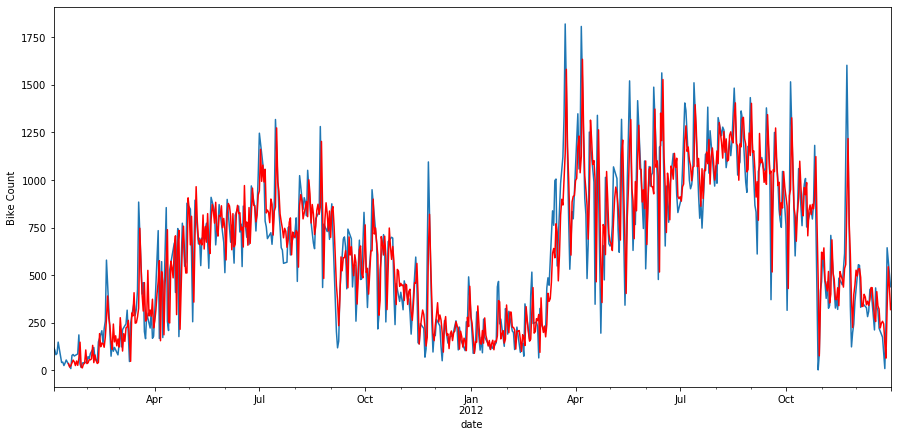

In [18]:
bikes['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
bikes['count'].plot()
bikes.model[13:].plot(color='r')
plt.ylabel('Bike Count')
pylab.show()

### Прогноз

In [20]:
### bikes2 = bikes[['count']]
date_list = [datetime.datetime.strptime("2013-01-31", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= bikes2.columns)
bikes2 = pd.concat([bikes2, future])
bikes2['forecast'] = invboxcox(best_model.predict(start=720, end=), lmbda)

plt.figure(figsize(8,7))
bikes2['count'].plot()
bikes2.forecast.plot(color='r')
plt.xlabel('years')
plt.ylabel('Bike Count')
pylab.show()

NameError: name 'bikes2' is not defined